# 3D Rayleigh-Bénard: Equivariant Convolutional Autoencoder

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.append('..')

from IPython.display import Video

from utils import training
from utils.model_building import build_model
from utils.evaluation import load_latent_sensitivity
from utils.visualization import show_latent_patterns

2025-01-16 12:53:15.094021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 12:53:15.278884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 12:53:16.071648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyperparameters

In [19]:
MODEL_TYPE = 'steerableCNN' # steerableCNN, steerable3DCNN, CNN, 3DCNN

HYPERPARAMETERS = {
    'simulation_name': 'x48_y48_z32_Ra2500_Pr0.7_t0.01_snap0.125_dur300',
    'rots': 4,
    'flips': True,
    'latent_channels': 32,
    'h_kernel_size': 3,
    'v_kernel_size': 3,
    'drop_rate': 0.2,
    'nonlinearity': 'ELU'
}

match MODEL_TYPE:
    case 'steerableCNN':
        encoder_channels = {
            (True, 4): (8, 16, 32, 64)
        }[(HYPERPARAMETERS['flips'], HYPERPARAMETERS['rots'])]
    case 'steerable3DCNN':
        encoder_channels = {
            (True, 4): (24, 48, 96, 192)
        }[(HYPERPARAMETERS['flips'], HYPERPARAMETERS['rots'])]
    case 'CNN':
        encoder_channels = (16, 32, 66, 160)
    case '3DCNN':
        encoder_channels = (40, 80, 168, 320)

## Model Definition

In [26]:
encoder_channels = (10, 20, 42, 84)
model = build_model(MODEL_TYPE, encoder_channels=encoder_channels, **HYPERPARAMETERS)

model.summary()

+--------------+--------------------------------+------------+
| Layer        | Output shape [c, |G|, w, d, h] | Parameters |
+--------------+--------------------------------+------------+
| Input        |             [4, 1, 48, 48, 32] |          0 |
| EncoderConv1 |            [10, 8, 48, 48, 32] |     23,680 |
| Pooling1     |            [10, 8, 24, 24, 16] |          0 |
| EncoderConv2 |            [20, 8, 24, 24, 16] |    461,440 |
| Pooling2     |             [20, 8, 12, 12, 8] |          0 |
| EncoderConv3 |             [42, 8, 12, 12, 8] |    968,352 |
| Pooling3     |               [42, 8, 6, 6, 4] |          0 |
| EncoderConv4 |               [84, 8, 6, 6, 4] |  2,032,800 |
| Pooling4     |               [84, 8, 3, 3, 2] |          0 |
| LatentConv   |                [4, 8, 3, 3, 2] |     96,784 |
| DecoderConv1 |               [84, 8, 3, 3, 2] |     97,104 |
| Upsampling1  |               [84, 8, 6, 6, 4] |          0 |
| DecoderConv2 |               [42, 8, 6, 6, 4] |  2,03

## Load Trained Model

In [1]:
MODEL_NAME = 'D4cnn' # 3Dcnn, cnn, D4cnn, ...
TRAIN_NAME = 'training2_lr1e-4'

In [8]:
EPOCH = -1

models_dir = './trained_models'
model = training.build_and_load_trained_model(models_dir, MODEL_NAME, TRAIN_NAME, EPOCH)

model.summary()

Loaded state at epoch 201 with an early stop count of 0.
+--------------+--------------------------------+------------+
| Layer        | Output shape [c, |G|, w, d, h] | Parameters |
+--------------+--------------------------------+------------+
| Input        |             [4, 1, 48, 48, 32] |          0 |
| EncoderConv1 |             [8, 8, 48, 48, 32] |     31,232 |
| Pooling1     |             [8, 8, 24, 24, 16] |          0 |
| EncoderConv2 |            [16, 8, 24, 24, 16] |    492,032 |
| Pooling2     |             [16, 8, 12, 12, 8] |          0 |
| EncoderConv3 |             [32, 8, 12, 12, 8] |    983,552 |
| Pooling3     |               [32, 8, 6, 6, 4] |          0 |
| EncoderConv4 |               [64, 8, 6, 6, 4] |  1,966,592 |
| Pooling4     |               [64, 8, 3, 3, 2] |          0 |
| LatentConv   |                [4, 8, 3, 3, 2] |    122,896 |
| DecoderConv1 |               [64, 8, 3, 3, 2] |    123,136 |
| Upsampling1  |               [64, 8, 6, 6, 4] |          0 

/upb/users/f/frommef/profiles/unix/cs/rb-equivariant-cnns/experiments/utils/training.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)

## Evaluation

### Output Animation

In [5]:
FEATURE = 't' # t, u, v, w
DIM = 'height' # width, depth, height

anim_dir = os.path.join('.', 'animations', MODEL_NAME, TRAIN_NAME)
Video(os.path.join(os.path.join(anim_dir, FEATURE), f'{DIM}.mp4'))

### Latent Space Visualization (Input Sensitivity)

__Load Sensitivity Data__

In [3]:
sensitivity_dir = os.path.join('.', 'results', MODEL_NAME, TRAIN_NAME)
avg_sensitivity, avg_abs_sensitivity, n = load_latent_sensitivity(sensitivity_dir, 'latent_sensitivity')

print(f'Latent sensitivity averaged over {n} samples')

/upb/users/f/frommef/profiles/unix/cs/rb-equivariant-cnns/experiments/utils/evaluation.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sensitivity_data = torch.load(os.

Latent sensitivity averaged over 8020 samples


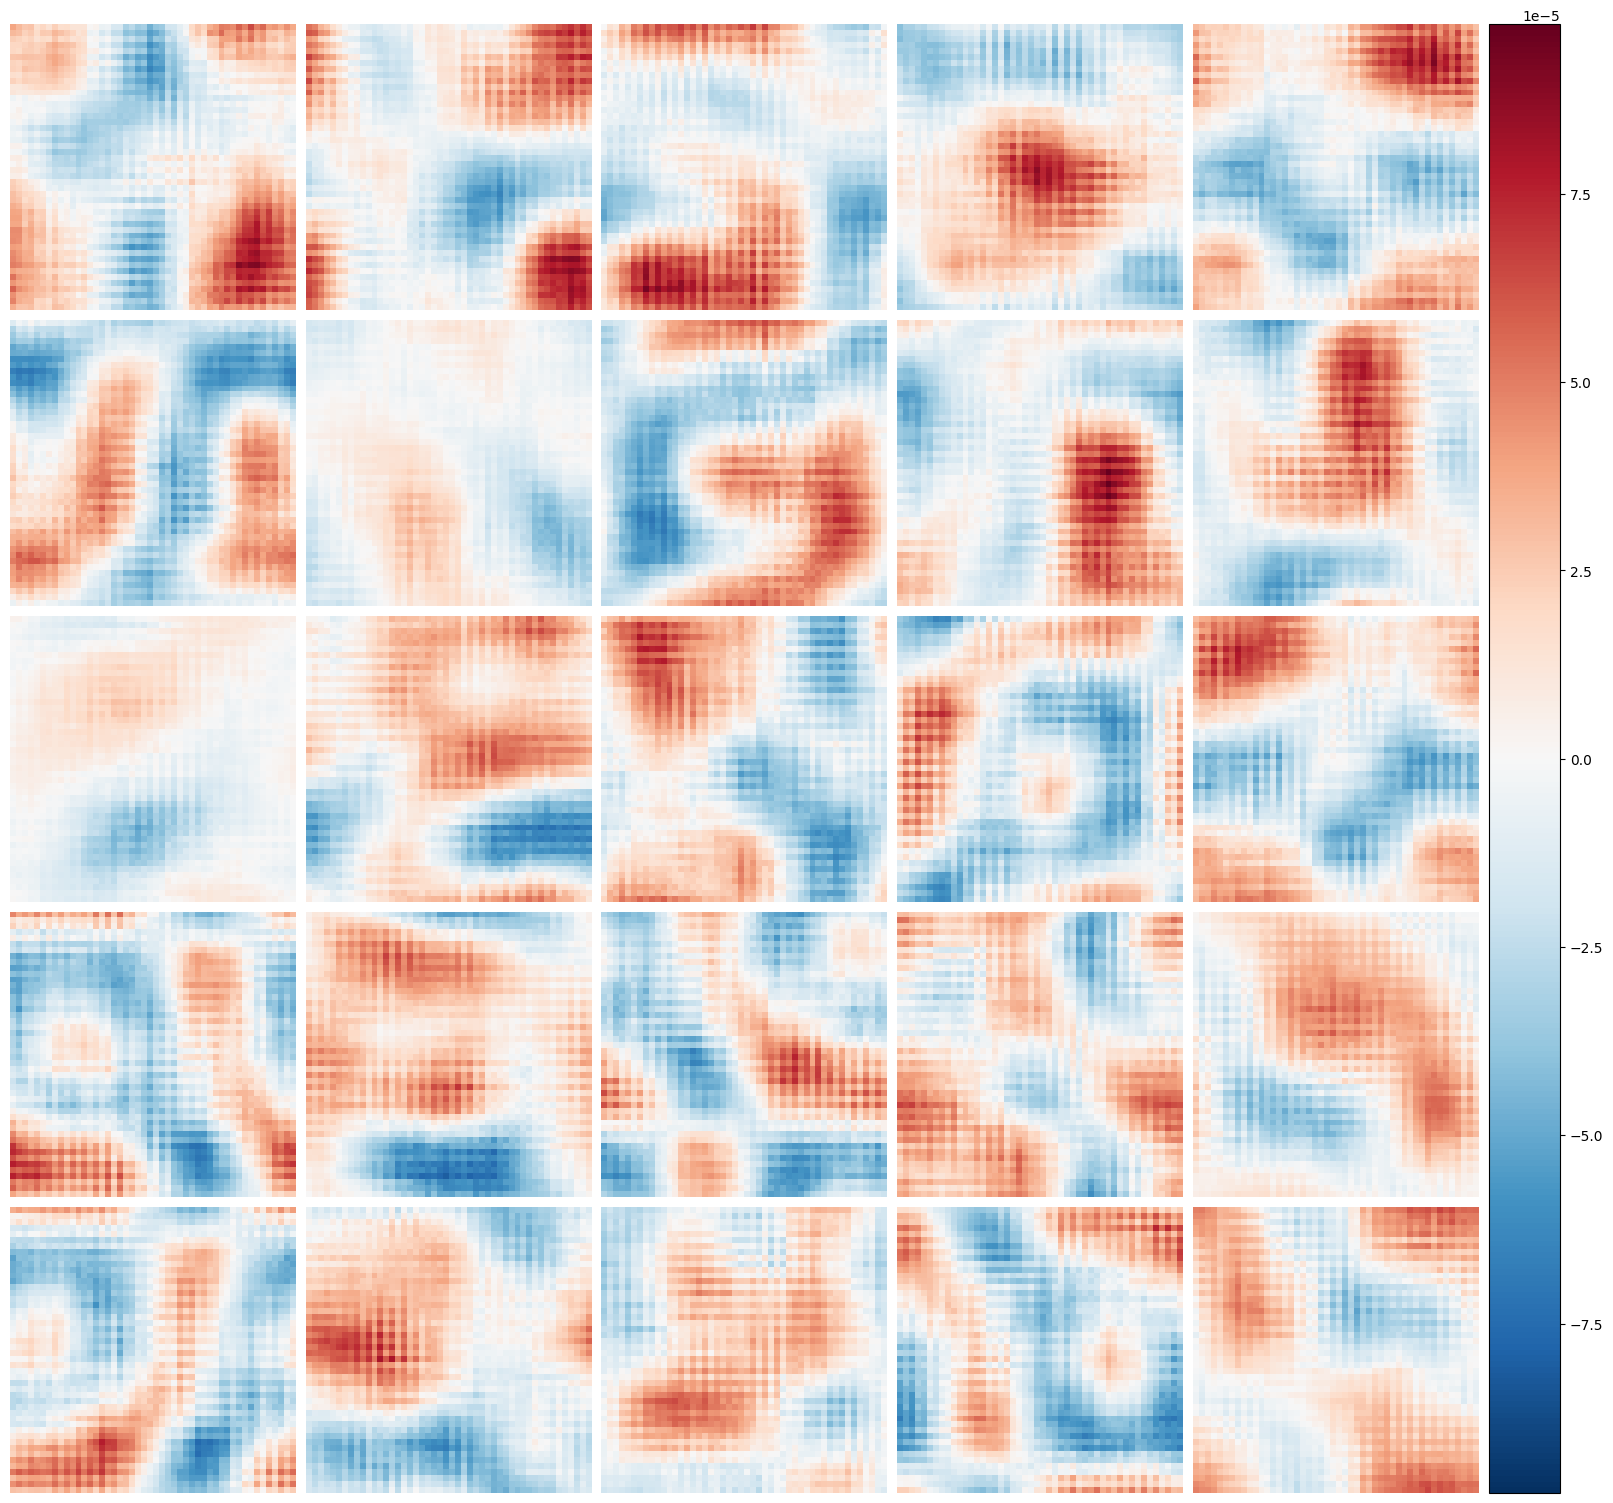

In [15]:
ABS_SENSITIVITY = False
FEATURE = 't'
SLICE = 0
AXIS = 2
NUM_PATTERNS = 25
CONTOUR = False


sensitivity_data = avg_abs_sensitivity if ABS_SENSITIVITY else avg_sensitivity
channel = 'tuvw'.index(FEATURE)
show_latent_patterns(avg_sensitivity, ABS_SENSITIVITY, NUM_PATTERNS, channel, SLICE, AXIS, contour=CONTOUR)